In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
random_int8 = torch.randint(-128, 127, (32, 16)).to(torch.int8)
random_hs = torch.randn((1, 16), dtype=torch.bfloat16)
scales = torch.randn((1, 32), dtype=torch.bfloat16)
bias = torch.randn((1, 32), dtype=torch.bfloat16)

In [3]:
F.linear(random_hs, random_int8.to(random_hs.dtype))

tensor([[  65.0000,   -4.5938, -182.0000, -426.0000, -394.0000,  154.0000,
          450.0000,  202.0000,  332.0000,   14.2500,  -74.5000,  -76.0000,
          105.0000, -496.0000,  520.0000,  -23.1250, -282.0000,  334.0000,
          -87.5000, -135.0000, -354.0000,   48.2500, -169.0000,    7.3125,
          446.0000,  215.0000, -304.0000,  -70.5000,  302.0000,  456.0000,
          470.0000,  286.0000]], dtype=torch.bfloat16)

In [4]:
F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales

tensor([[ 5.8500e+01,  4.8750e+00, -7.2000e+01, -1.1680e+03, -4.0000e+02,
          3.9500e+01, -1.8300e+02,  2.6250e+01, -3.3800e+02,  1.4453e+00,
         -3.2500e+01,  6.7500e+01,  1.1150e+02,  1.8500e+02, -5.0200e+02,
          4.3500e+01, -3.8200e+02,  5.6800e+02,  1.1300e+02, -2.0500e+02,
          3.2000e+02, -4.8750e+01,  1.8400e+02,  2.0020e-01,  0.0000e+00,
         -4.6500e+01,  5.8800e+02, -1.1800e+02,  2.3200e+02, -3.5500e+01,
          5.9200e+02,  3.2600e+02]], dtype=torch.bfloat16)

In [5]:
F.linear(random_hs, random_int8.to(random_hs.dtype)) * scales + bias

tensor([[ 5.8750e+01,  6.0625e+00, -7.0500e+01, -1.1680e+03, -4.0000e+02,
          4.1000e+01, -1.8400e+02,  2.7625e+01, -3.3600e+02,  1.7656e+00,
         -3.2500e+01,  6.8500e+01,  1.1250e+02,  1.8500e+02, -5.0200e+02,
          4.3000e+01, -3.8200e+02,  5.6800e+02,  1.1350e+02, -2.0500e+02,
          3.2000e+02, -4.7000e+01,  1.8200e+02,  7.9688e-01, -5.7031e-01,
         -4.7250e+01,  5.8800e+02, -1.1700e+02,  2.3200e+02, -3.4250e+01,
          5.9200e+02,  3.2600e+02]], dtype=torch.bfloat16)

In [6]:
# put everything inside a function
def w8_a16_forward(weight, input, scales, bias=None):
    casted_weights = weight.to(input.dtype)
    output = F.linear(input, casted_weights) * scales
    if bias is not None:
        output = output + bias
    return output

In [7]:
print("With bias: ", w8_a16_forward(random_int8, random_hs, scales, bias))
print("Without bias: ", w8_a16_forward(random_int8, random_hs, scales))

With bias:  tensor([[ 5.8750e+01,  6.0625e+00, -7.0500e+01, -1.1680e+03, -4.0000e+02,
          4.1000e+01, -1.8400e+02,  2.7625e+01, -3.3600e+02,  1.7656e+00,
         -3.2500e+01,  6.8500e+01,  1.1250e+02,  1.8500e+02, -5.0200e+02,
          4.3000e+01, -3.8200e+02,  5.6800e+02,  1.1350e+02, -2.0500e+02,
          3.2000e+02, -4.7000e+01,  1.8200e+02,  7.9688e-01, -5.7031e-01,
         -4.7250e+01,  5.8800e+02, -1.1700e+02,  2.3200e+02, -3.4250e+01,
          5.9200e+02,  3.2600e+02]], dtype=torch.bfloat16)
Without bias:  tensor([[ 5.8500e+01,  4.8750e+00, -7.2000e+01, -1.1680e+03, -4.0000e+02,
          3.9500e+01, -1.8300e+02,  2.6250e+01, -3.3800e+02,  1.4453e+00,
         -3.2500e+01,  6.7500e+01,  1.1150e+02,  1.8500e+02, -5.0200e+02,
          4.3500e+01, -3.8200e+02,  5.6800e+02,  1.1300e+02, -2.0500e+02,
          3.2000e+02, -4.8750e+01,  1.8400e+02,  2.0020e-01,  0.0000e+00,
         -4.6500e+01,  5.8800e+02, -1.1800e+02,  2.3200e+02, -3.5500e+01,
          5.9200e+02,  3.2

In [8]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, dtype=torch.float32):
        super().__init__()
        # the right approach to save int8 weights, Parameters won't work with torch.int8
        self.register_buffer(
            "int8_weights",
            torch.randint(-128, 127, (out_features, in_features),dtype=torch.int8)
        )
        
        self.register_buffer("scales",
                torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias",
                torch.randn((1, out_features), dtype=dtype))
        else:
            self.bias = None
            
    def forward(self, input):
        return w8_a16_forward(self.int8_weights, input, self.scales, self.bias)

In [9]:
module = W8A16LinearLayer(16, 32)
dummy_hidden_states = torch.randn(1, 6, 16)

In [10]:
module(dummy_hidden_states).shape, module(dummy_hidden_states).dtype

(torch.Size([1, 6, 32]), torch.float32)

In [11]:
class W8A16LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, dtype=torch.float32):
        super().__init__()
        # the right approach to save int8 weights, Parameters won't work with torch.int8
        self.register_buffer(
            "int8_weights",
            torch.randint(-128, 127, (out_features, in_features),dtype=torch.int8)
        )
        
        self.register_buffer("scales",
                torch.randn((out_features), dtype=dtype))
        
        if bias:
            self.register_buffer("bias",
                torch.randn((1, out_features), dtype=dtype))
        else:
            self.bias = None
    
    def quantize(self, weights):
        # see LinearQuantization per channel on how scales and weights are derived
        w_fp32 = weights.clone().to(torch.float32)
        scales = w_fp32.abs().max(dim=-1).values / 127
        scales = scales.to(weights.dtype)
        
        int8_weights = torch.round(weights / scales.unsqueeze(1)).to(torch.int8)
        self.int8_weights = int8_weights
        self.scales = scales
        
    def forward(self, input):
        return w8_a16_forward(self.int8_weights, input, self.scales, self.bias)

In [12]:
module = W8A16LinearLayer(4, 8)
print("Weights before: ", module.int8_weights)

Weights before:  tensor([[   3,  108,  110,   92],
        [ -26, -123, -124,  -32],
        [ 101,   45,  -72,  -81],
        [ -93,  111,  120,   52],
        [ -61,  -38,    4,   47],
        [-101,   96,   27,   46],
        [ -69,   -2,   35,  123],
        [  87,   -9, -122,  -26]], dtype=torch.int8)


In [13]:
random_matrix = torch.randn((4, 8), dtype=torch.bfloat16)
module.quantize(random_matrix)
print("Weights after: ", module.int8_weights)

Weights after:  tensor([[  94, -127,   78,   -4,  -71,    4,   32,   13],
        [ -59,  -44,   24, -122,   79,  -44,   57, -128],
        [ -24,  -61,   53,  -35,  -60,  -58,   42,  127],
        [ -26,  -44,  -38,  -81,   68,  -54,   14, -127]], dtype=torch.int8)


In [14]:
module.scales

tensor([0.0168, 0.0106, 0.0144, 0.0135], dtype=torch.bfloat16)

In [15]:
# Compare weights
module.int8_weights * module.scales.unsqueeze(1)

tensor([[ 1.5859, -2.1406,  1.3125, -0.0674, -1.1953,  0.0674,  0.5391,  0.2188],
        [-0.6250, -0.4668,  0.2539, -1.2969,  0.8398, -0.4668,  0.6055, -1.3594],
        [-0.3457, -0.8789,  0.7617, -0.5039, -0.8633, -0.8359,  0.6055,  1.8281],
        [-0.3516, -0.5938, -0.5117, -1.0938,  0.9180, -0.7266,  0.1885, -1.7109]],
       dtype=torch.bfloat16)

In [16]:
random_matrix

tensor([[ 1.5859, -2.1406,  1.3047, -0.0723, -1.1953,  0.0618,  0.5469,  0.2217],
        [-0.6250, -0.4727,  0.2598, -1.2891,  0.8398, -0.4688,  0.6016, -1.3516],
        [-0.3477, -0.8789,  0.7617, -0.5039, -0.8633, -0.8320,  0.6016,  1.8281],
        [-0.3438, -0.5938, -0.5156, -1.0938,  0.9141, -0.7227,  0.1826, -1.7109]],
       dtype=torch.bfloat16)

In [17]:
(random_matrix - module.int8_weights * module.scales.unsqueeze(1)).abs().mean().item()

0.0030517578125

### Replace PyTorch layers with Quantized Layers

In [18]:
def replace_linear_with_target(module, target_class, module_name_to_exclude):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and \
            not any([x == name for x in module_name_to_exclude]):
                new_module = target_class(child.in_features,
                                          child.out_features,
                                          child.bias is not None,
                                          child.weight.dtype)
                setattr(module, name, new_module)
                if child.bias is not None:
                    getattr(module, name).bias = child.bias
        else:
            # Recursively call the function for nested modules
            replace_linear_with_target(
                child, target_class, module_name_to_exclude
            )

In [19]:
class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = torch.nn.Embedding(1, 1)
        self.linear_1 = nn.Linear(1, 1)
        self.linear_2 = nn.Linear(1, 1, bias=False)
        
        # lm prediction head
        self.lm_head = nn.Linear(1, 1, bias=False)

In [20]:
model_1 = DummyModel()
model_2 = DummyModel()

In [21]:
replace_linear_with_target(model_1, W8A16LinearLayer, ["lm_head"])
print(model_1)

DummyModel(
  (emb): Embedding(1, 1)
  (linear_1): W8A16LinearLayer()
  (linear_2): W8A16LinearLayer()
  (lm_head): Linear(in_features=1, out_features=1, bias=False)
)


In [22]:
replace_linear_with_target(model_2, W8A16LinearLayer, [])
print(model_2)

DummyModel(
  (emb): Embedding(1, 1)
  (linear_1): W8A16LinearLayer()
  (linear_2): W8A16LinearLayer()
  (lm_head): W8A16LinearLayer()
)


In [23]:
def replace_linear_with_target_and_quantize(module, target_class, module_name_to_exclude):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear) and \
            not any([x == name for x in module_name_to_exclude]):
                old_weight = child.weight
                new_module = target_class(child.in_features,
                                          child.out_features,
                                          child.bias is not None,
                                          child.weight.dtype)
                setattr(module, name, new_module)
                getattr(module, name).quantize(old_weight)
                if child.bias is not None:
                    getattr(module, name).bias = child.bias
        else:
            # Recursively call the function for nested modules
            replace_linear_with_target_and_quantize(
                child, target_class, module_name_to_exclude
            )

In [24]:
model3 = DummyModel()

In [25]:
replace_linear_with_target_and_quantize(model3, W8A16LinearLayer, ["lm_head"])
print(model3)

DummyModel(
  (emb): Embedding(1, 1)
  (linear_1): W8A16LinearLayer()
  (linear_2): W8A16LinearLayer()
  (lm_head): Linear(in_features=1, out_features=1, bias=False)
)


### Quantize open source models

In [31]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_id = "Salesforce/codegen-350M-mono"

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             torch_dtype=torch.bfloat16,
                                             low_cpu_mem_usage=True)
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [32]:
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

In [33]:
print(pipe("def hello_world():", max_new_tokens=20, do_sample=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'def hello_world():\n    print("Hello World")\n\nhello_world()\n\n# 파'}]


In [34]:
print("Model before:", model)

Model before: CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (mlp): CodeGenMLP(
          (fc_in): Linear(in_features=1024, out_features=4096, bias=True)
          (fc_out): Linear(in_features=4096, out_features=1024, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias

In [35]:
replace_linear_with_target_and_quantize(model,
                                        W8A16LinearLayer, ["lm_head"])

In [36]:
pipe.model

CodeGenForCausalLM(
  (transformer): CodeGenModel(
    (wte): Embedding(51200, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-19): 20 x CodeGenBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CodeGenAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (qkv_proj): W8A16LinearLayer()
          (out_proj): W8A16LinearLayer()
        )
        (mlp): CodeGenMLP(
          (fc_in): W8A16LinearLayer()
          (fc_out): W8A16LinearLayer()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=51200, bias=True)
)

In [37]:
print(pipe("def hello_world():", max_new_tokens=20, do_sample=False)[0]["generated_text"])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


def hello_world():
    print("Hello World")

# hello_world()

# def hello_


In [38]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm"
)
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm"
)

In [39]:
previous_memory_footprint = model.get_memory_footprint()

In [40]:
previous_memory_footprint

166524032

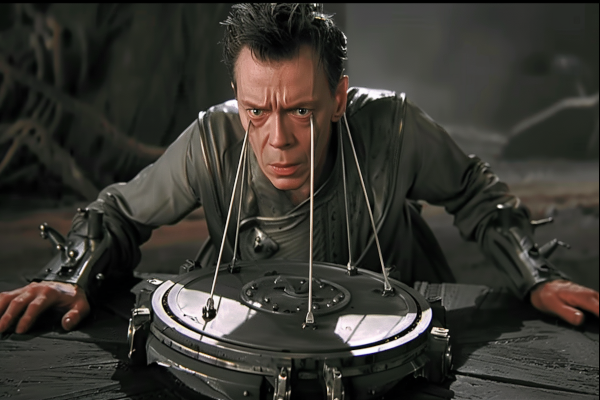

In [41]:
img_path = "images/to_detect.png"
image = Image.open(img_path).convert("RGB")
image

In [55]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# helper function
def plot_results(model, pil_img, results):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    scores, labels, boxes = results["scores"], results["labels"], results["boxes"]
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [56]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes)

In [57]:
results

[{'scores': tensor([0.9950, 0.5291]),
  'labels': tensor([1, 4]),
  'boxes': tensor([[-1.5635e-01,  3.2196e+00,  5.9973e+02,  3.3935e+02],
          [ 3.7279e+00,  2.0652e+02,  5.9420e+02,  3.9684e+02]])}]

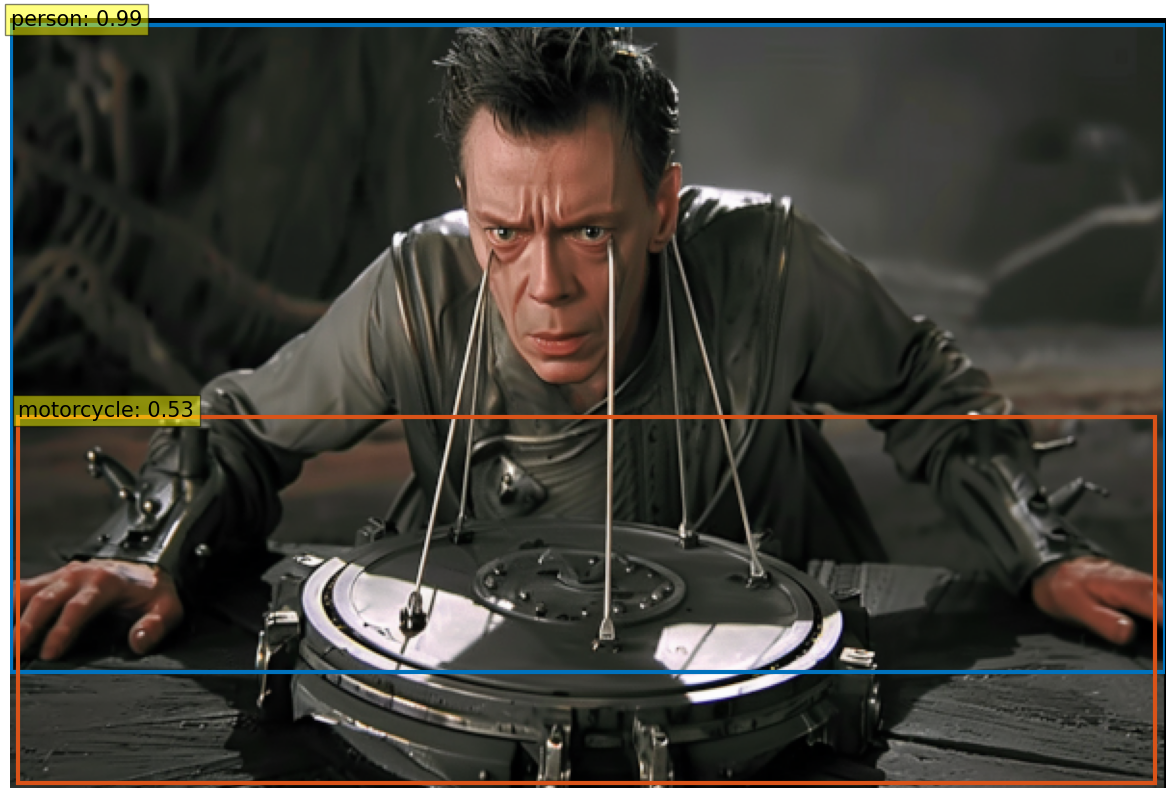

In [58]:
plot_results(model, image, results[0])

In [59]:
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [60]:
replace_linear_with_target_and_quantize(model, W8A16LinearLayer, ["0", "1", "2", "class_labels_classifier"])

In [61]:
model

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): DetrFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBottleNeckLayer(
                    (shortcut): ResNetShortCut(
                      (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                      (normalization): DetrFrozenBatchNorm2d()
                    )
                    (layer): Seq

In [62]:
inputs = processor(images=image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes)

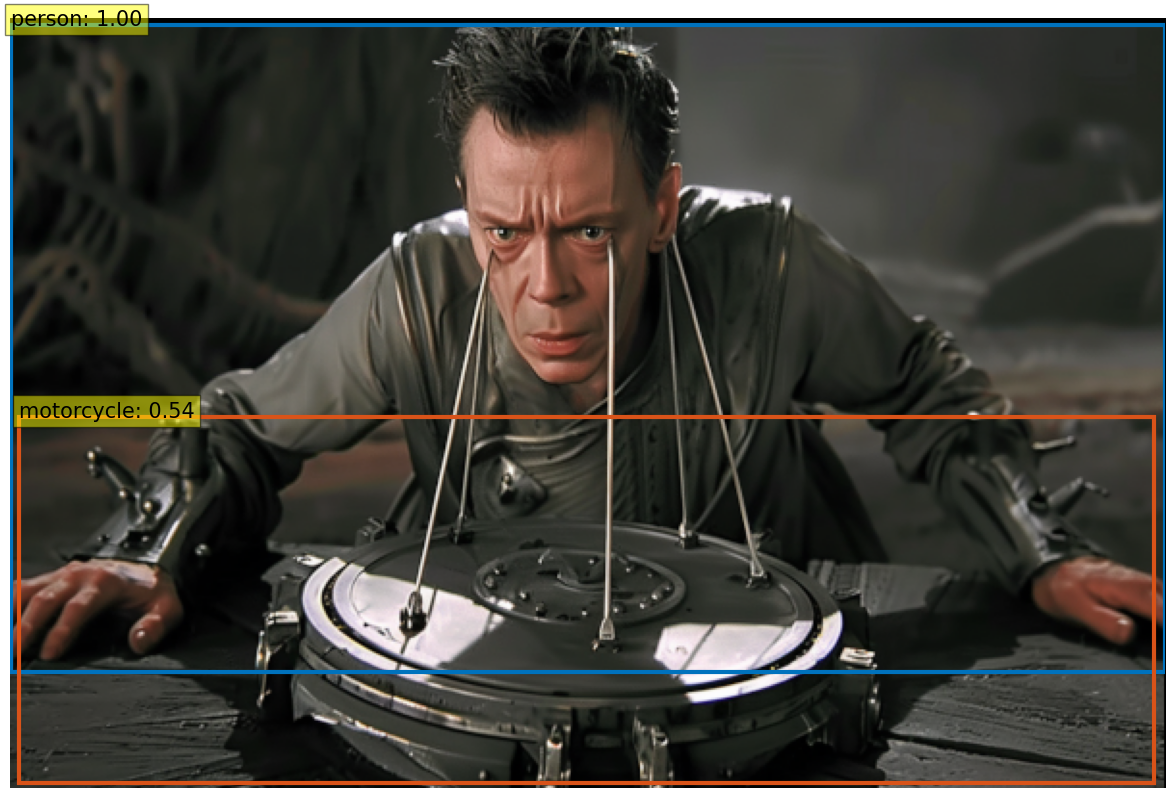

In [63]:
plot_results(model, image, results[0])

In [64]:
new_footprint = model.get_memory_footprint()
new_footprint

114803840

### Saving the weights so they can be loaded on lower mem machine

In [65]:
quantized_state_dict = model.state_dict()
torch.save(quantized_state_dict, "quantized_state_dict.pth")

In [ ]:
# upploading to Hugging Face
from huggingface_hub import HfAPI, create_repo

username = ""
repo_id = f"{username}/opt-125m-quantized-dlai"

api = HfApi()

# create_repo(repo_id)

api.upload_file(
    path_or_fileobj="quantized_state_dict.pth",
    path_in_repo="quantized_state_dict.pth",
    repo_id=repo_id
)

### Loading a quantized model

In [68]:
import torch
from transformers import OPTForCausalLM, AutoTokenizer, AutoConfig

model_id = "facebook/opt-125m"
config = AutoConfig.from_pretrained(model_id)

with torch.device("meta"):
    model = OPTForCausalLM(config)
    
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [69]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor(..., device='meta', size=(50272, 768), requires_grad=True)
Parameter containing:
tensor(..., device='meta', size=(2050, 768), requires_grad=True)
Parameter containing:
tensor(..., device='meta', size=(768,), requires_grad=True)
Parameter containing:
tensor(..., device='meta', size=(768,), requires_grad=True)
Parameter containing:
tensor(..., device='meta', size=(768, 768), requires_grad=True)
Parameter containing:
tensor(..., device='meta', size=(768,), requires_grad=True)
Parameter containing:
tensor(..., device='meta', size=(768, 768), requires_grad=True)
Parameter containing:
tensor(..., device='meta', size=(768,), requires_grad=True)
Parameter containing:
tensor(..., device='meta', size=(768, 768), requires_grad=True)
Parameter containing:
tensor(..., device='meta', size=(768,), requires_grad=True)
Parameter containing:
tensor(..., device='meta', size=(768, 768), requires_grad=True)
Parameter containing:
tensor(..., device='meta', size=(768,), requires_

In [70]:
model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), ep

In [72]:
replace_linear_with_target(model, W8A16LinearLayer, ["lm_head"])

In [73]:
model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): W8A16LinearLayer()
            (v_proj): W8A16LinearLayer()
            (q_proj): W8A16LinearLayer()
            (out_proj): W8A16LinearLayer()
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): W8A16LinearLayer()
          (fc2): W8A16LinearLayer()
          (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
  )
  (lm_head): Linear(in_features=768, out_features=50272, bias=False)
)

In [ ]:
import torch
from huggingface_hub import hf_hub_download

state_dict_cache_path = hf_hub_download(
    f"{username}/opt-125m-quantized-dlai",
    "quantized_state_dict.pth"
)

In [ ]:
state_dict = torch.load(state_dict_cache_path)
model.load_state_dict(state_dict, strict=True, assign=True)